In [1]:
# set up environment

import warnings;
warnings.filterwarnings('ignore');
import pandas as pd
import os.path as op
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
InteractiveShell.ast_node_interactivity = "all"
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
import matplotlib.pyplot as plt;
from matplotlib.lines import Line2D;
import sys
import scipy.stats


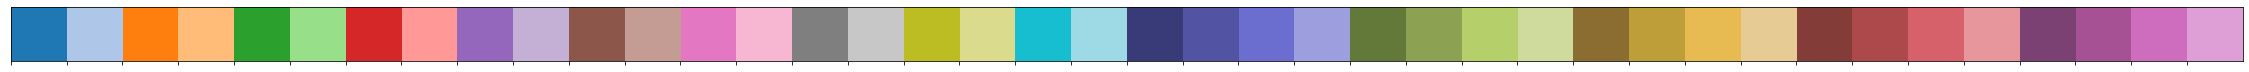

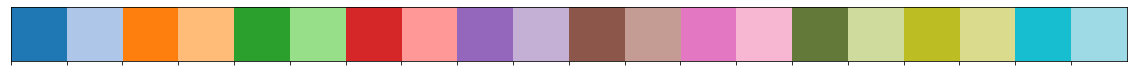

In [2]:
#plotting parameters, these will the same for all plots

x_labels=['Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (pos -> ant)','Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (inf -> sup)', 'Node (inf -> sup)',
          'Node (lh -> rh)', 'Node (lh -> rh)',
          'Node (pos -> ant)','Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)'];

tracts=['AF', 'AF', 'ATR', 'ATR', 'CC', 'CC',
        'CS', 'CS', 'FcMi', 'FcMa','IFOF', 'IFOF',
        'ILF', 'ILF', 'MLF', 'MLF','SLF', 'SLF', 
        'UNC', 'UNC'];

tractPos = {'ATR': (0, 0), 'CS': (0, 1), 'CC': (0, 2), 'FcMi': (0, 4), 'FcMa': (0, 5),
            'IFOF': (1, 2), 'ILF':(1,0), 'MLF':(1,1), 'SLF':(1,3), 'UNC':(1,4), 'AF': (1, 5)};

color_list_all=sns.color_palette("tab20")+sns.color_palette("tab20b") 
color_list_complete=color_list_all
color_list_chosen=color_list_all[0:14]
color_list_chosen.extend(color_list_all[24:25])
color_list_chosen.extend(color_list_all[27:28])
color_list_chosen.extend(color_list_all[16:20]) 
sns.palplot(color_list_all)
sns.palplot(color_list_chosen)
color_list_all=color_list_chosen
color_order=[19, 18, 1, 0, 5, 4, 3, 2, 7, 6, 9, 8, 11, 10, 15, 14, 13, 12, 17, 16]


In [3]:
#load all data from local folder

# load participant information
if not op.exists('./data/participants.csv'):
    parts = pd.read_csv(op.join(prefix, './data/participants.tsv'), sep='\t')
    parts.to_csv('./data/participants.csv')
else: 
    parts = pd.read_csv('./data/participants.csv', index_col=0)
#parts
#parts.shape

#load QC data from local folder
if not op.exists('./data/combined.csv'):
    QC = pd.read_csv(op.join('./data/combined.tsv'), sep='\t')
    QC.to_csv('./data/QC_combined.csv')
else: 
    QC = pd.read_csv('./data/QC_combined.csv', index_col=0)
#QC
#QC.shape

#load session information from local folder
if not op.exists("./data/sessions.csv"):
    df_list = []
    for part in parts['./data/participant_id']:
        part_folder = f"dhcp-afq/dhcp_dmri_pipeline/sub-{part}/"
        part_session_file = f's3://{part_folder}sub-{part}_sessions.tsv'
        this_df = pd.read_csv(part_session_file, sep="\t")
        # This will be our foreign key for merging:
        this_df["participant_id"] = part
        df_list.append(this_df)
    sessions = pd.concat(df_list)
    sessions.to_csv("./data/sessions.csv")
else: 
    sessions = pd.read_csv('./data/sessions.csv')

sessions.rename(columns={"Unnamed: 0": "session_index"}, inplace=True)
#sessions.head()
#sessions.shape

#load tract profiles from local folder
if not op.exists ("./data/tract_profiles.csv"):
    tract_profiles = pd.read_csv("s3://dhcp-afq/afq/combined_tract_profiles.csv")
    tract_profiles.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)
    tract_profiles.to_csv("./data/tract_profiles_with_r1_nonorm.csv")
else:
    tract_profiles = pd.read_csv("./data/tract_profiles_with_r1_nonorm.csv", index_col=0)
#tract_profiles.head()
#tract_profiles.shape
#sessions.head()
#sessions.shape
#uniqueSubjects=sessions['participant_id'].unique()
#print(uniqueSubjects)
#uniqueSubjects.shape

In [4]:
#perform quality control

#merge session and QC data, set QC treshhold

sessionsQC = pd.merge(QC, sessions, on=["session_id","participant_id"], how="inner")
sessionsQC.shape
#sessionsQC.head(20)
sessionsQC["qc_dmri_eddy_abs_motion"].mean()
sessionsQC["qc_dmri_eddy_abs_motion"].std()
motion_cutoff=sessionsQC["qc_dmri_eddy_abs_motion"].mean()+2*sessionsQC["qc_dmri_eddy_abs_motion"].std()
print(motion_cutoff)
sessionsQC["qc_dmri_eddy_percent_outlier_slices"].mean()
sessionsQC["qc_dmri_eddy_percent_outlier_slices"].std()
outlier_cutoff=sessionsQC["qc_dmri_eddy_percent_outlier_slices"].mean()+2*sessionsQC["qc_dmri_eddy_percent_outlier_slices"].std()
print(outlier_cutoff)

sessions_afterQC=sessionsQC[sessionsQC["qc_dmri_eddy_abs_motion"]<motion_cutoff]
sessions_afterQC=sessions_afterQC[sessions_afterQC["qc_dmri_eddy_percent_outlier_slices"]<outlier_cutoff]
sessions_afterQC.shape
sessionsAfterQC=sessions[sessions["session_id"].isin(sessions_afterQC["session_id"])]
sessionsAfterQC.shape
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00530XX11'];
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00129AN14'];
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00822XX14'];
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00766XX16'];
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00572CN12'];
sessionsAfterQC.shape

# load sl count for local storage and remove bundles with fever than 11 streamlines
subjects = pd.merge(parts, sessionsAfterQC, on="participant_id", how="inner")
subjects=subjects[subjects["session_id"].isin(tract_profiles["sessionID"])]

subjects.rename(columns={"participant_id": "subjectID"}, inplace=True)
subjects.rename(columns={"session_id": "sessionID"}, inplace=True)
subjects.to_csv("./data/subjects.csv")
#subjects.head()

allDataMerged=pd.merge(tract_profiles,subjects,on=['subjectID','sessionID'])
allDataMerged.head()
allDataMerged.shape

sl_count_all=pd.read_csv("./data/dHCP_sl_count.csv")
low_sl_count=sl_count_all[sl_count_all['n_streamlines_clean']<=10]['subject_id'].unique()
low_sl_count.shape

allDataCleaned=allDataMerged[~allDataMerged["subjectID"].isin(low_sl_count)]
allDataCleaned.shape

subjects.shape
subjectsCleaned=subjects[~subjects["subjectID"].isin(low_sl_count)]
subjectsCleaned.shape

tract_profilesCleaned=tract_profiles[~tract_profiles["subjectID"].isin(low_sl_count)]
#tract_profilesCleaned.shape

sessionsAfterQC.shape
sessionsCleaned=sessionsAfterQC[~sessionsAfterQC["participant_id"].isin(low_sl_count)]
sessionsCleaned.shape


(490, 45)

1.9578367346938785

0.9013503922044679

3.7605375191028143


4.484728061224486

1.7722473727436072

8.0292228067117


(450, 45)

(450, 8)

(445, 8)

,R1,tractID,nodeID,subjectID,sessionID,dti_fa,dti_md,dki_fa,dki_md,dki_mk,gender,birth_age,birth_weight,singleton,session_index,scan_age,scan_head_circumference,scan_number,radiology_score,sedation
0,1.140926,ARC_R,0,CC00549XX22,157600,0.164937,0.001084,0.174596,0.001122,0.181780,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0
1,0.908792,ARC_R,1,CC00549XX22,157600,0.176538,0.001116,0.186956,0.001153,0.172582,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0
2,0.830609,ARC_R,2,CC00549XX22,157600,0.189404,0.001148,0.200261,0.001186,0.169051,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0
3,0.817228,ARC_R,3,CC00549XX22,157600,0.201964,0.001173,0.211598,0.001211,0.166378,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0
4,0.831267,ARC_R,4,CC00549XX22,157600,0.213557,0.001181,0.222664,0.001218,0.161257,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0


(850000, 20)

(25,)

(804000, 20)

(425, 12)

(402, 12)

(445, 8)

(421, 8)

In [5]:
#identify longi subjects
subjectsCleaned.shape
subjectsCLeanedLongi=subjectsCleaned[subjectsCleaned.duplicated(subset="subjectID")]
subjectsCLeanedLongi.shape

subjectsCleaned["isLongi"]=subjectsCleaned["subjectID"].isin(subjectsCLeanedLongi["subjectID"])
subjectsCleaned["isLongi"]=subjectsCleaned["isLongi"].astype(int)
subjectsCleaned["timeAfterBirth"]=subjectsCleaned['scan_age']-subjectsCleaned['birth_age']

subjectsCLeanedNoLongi=subjectsCleaned[~subjectsCleaned.duplicated(subset="subjectID")]
subjectsCLeanedNoLongi.shape
subjectsCLeanedNoLongi["timeAfterBirth"].mean()
subjectsCLeanedNoLongi["timeAfterBirth"].min()
subjectsCLeanedNoLongi["timeAfterBirth"].max()

subjectsCLeanedNoLongi["birth_age"].min()
subjectsCLeanedNoLongi["birth_age"].max()
#subjectsCleaned["subjectID"].unique
#subjects.head()
#subjects['scan_age'].hist()
#subjects['birth_age'].hist()


(402, 12)

(34, 12)

(368, 14)

1.6013198757764187

-2.8421709430404007e-13

16.714285714285

24.571428571429

42.285714285714

(34,)

(34,)

(34,)

(300, 16)

(34, 16)

(34, 16)

(34, 16)

34.34033613445382

(34, 16)

40.92016806722692

(34, 16)

40.9201680672269

(34, 16)

<AxesSubplot:>

31.96638655462191

(34, 16)

31.96638655462191

(34, 16)

40.07983193277305

(34, 16)

-2.8421709430404007e-13

16.714285714285

1.6000000000000179

<AxesSubplot:xlabel='timeAfterBirth', ylabel='Count'>

(850000, 20)

(804000, 20)

(804000, 24)

(600000, 24)

(68000, 24)

(68000, 24)

(68000, 24)

(20,)

(100,)

(4,)

['ARC_R' 'ARC_L' 'ATR_R' 'ATR_L' 'CGC_R' 'CGC_L' 'CST_R' 'CST_L' 'FA' 'FP'
 'IFO_R' 'IFO_L' 'ILF_R' 'ILF_L' 'MdLF_R' 'MdLF_L' 'SLF_R' 'SLF_L' 'UNC_R'
 'UNC_L']


,R1,tractID,nodeID,subjectID,sessionID,dti_fa,dti_md,dki_fa,dki_md,dki_mk,...,session_index,scan_age,scan_head_circumference,scan_number,radiology_score,sedation,isLongi,timeAfterBirth,matched,matched_groups
0,1.140926,ARC_R,0,CC00549XX22,157600,0.164937,0.001084,0.174596,0.001122,0.181780,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0
1,0.908792,ARC_R,1,CC00549XX22,157600,0.176538,0.001116,0.186956,0.001153,0.172582,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0
2,0.830609,ARC_R,2,CC00549XX22,157600,0.189404,0.001148,0.200261,0.001186,0.169051,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0
3,0.817228,ARC_R,3,CC00549XX22,157600,0.201964,0.001173,0.211598,0.001211,0.166378,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0
4,0.831267,ARC_R,4,CC00549XX22,157600,0.213557,0.001181,0.222664,0.001218,0.161257,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0


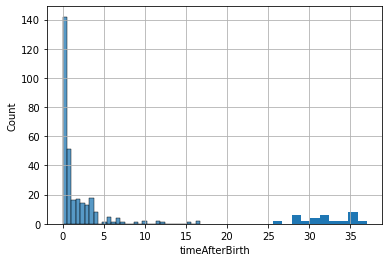

In [6]:
# assign matched labels to subjects table and all data table
#load the data that was matched sucessfully

matchedData=pd.read_csv('./data/matched_data_final.csv') #this table includes the single matches fro pymatch
#and Ariels nearest neighbor

subjectsCleaned["matched"]=0
#subjectsCleaned.head()
subjectsCleaned["matched"]=subjectsCleaned['subjectID'].isin(matchedData['subjectID']).astype(int)

subjectsCleaned["matched_groups"]=0
subjectsCleaned["matched_groups"][(subjectsCleaned["isLongi"]>0) & (subjectsCleaned['matched']>0) & (subjectsCleaned['scan_number']==1)]=1
subjectsCleaned["matched_groups"][subjectsCleaned["matched_groups"]==1].shape
subjectsCleaned["matched_groups"][(subjectsCleaned["isLongi"]>0) & (subjectsCleaned['matched']>0) & (subjectsCleaned['scan_number']==2)]=2
subjectsCleaned["matched_groups"][subjectsCleaned["matched_groups"]==2].shape
subjectsCleaned["matched_groups"][(subjectsCleaned["isLongi"]==0) & (subjectsCleaned['matched']>0)]=3
subjectsCleaned["matched_groups"][subjectsCleaned["matched_groups"]==3].shape
#subjectsCleaned.head()

subjectsCleaned[subjectsCleaned['matched_groups']==0].shape
subjectsCleaned[subjectsCleaned['matched_groups']==1].shape
subjectsCleaned[subjectsCleaned['matched_groups']==2].shape
subjectsCleaned[subjectsCleaned['matched_groups']==3].shape

subjectsCleanedMatched=subjectsCleaned[subjectsCleaned['matched_groups']>0]
age0=subjectsCleaned[subjectsCleaned['matched_groups']==1]
age0['scan_age'].mean()
age0.shape
age1=subjectsCleaned[subjectsCleaned['matched_groups']==2]
age1['scan_age'].mean()
age1.shape
age2=subjectsCleaned[subjectsCleaned['matched_groups']==3]
age2['scan_age'].mean()
age2.shape
age0['birth_age'].hist()

age3=subjectsCleaned[subjectsCleaned['matched_groups']==1]
age3['birth_age'].mean()
age3.shape
age4=subjectsCleaned[subjectsCleaned['matched_groups']==2]
age4['birth_age'].mean()
age4.shape
age5=subjectsCleaned[subjectsCleaned['matched_groups']==3]
age5['birth_age'].mean()
age5.shape

subjectsCleanedNonMatched=subjectsCleaned[subjectsCleaned['matched_groups']==0]
subjectsCleanedNonMatched['timeAfterBirth'].min()
subjectsCleanedNonMatched['timeAfterBirth'].max()
subjectsCleanedNonMatched['timeAfterBirth'].mean()
sns.histplot(subjectsCleanedNonMatched['timeAfterBirth'])


allDataMergedCleaned=pd.merge(tract_profilesCleaned,subjectsCleaned,on=['subjectID','sessionID'])
#allDataMergedCleaned.head(20)
allDataMerged.shape
allDataCleaned.shape
allDataMergedCleaned.shape

allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0].shape
allDataMergedCleaned[allDataMergedCleaned['matched_groups']==1].shape
allDataMergedCleaned[allDataMergedCleaned['matched_groups']==2].shape
allDataMergedCleaned[allDataMergedCleaned['matched_groups']==3].shape

tractCount=allDataMergedCleaned['tractID'].unique()
tractCount.shape
nodeCount=allDataMergedCleaned['nodeID'].unique()
nodeCount.shape
groupCount=allDataMergedCleaned['matched_groups'].unique()
groupCount.shape

print(tractCount)
allDataMergedCleaned.head()


In [14]:
### describing the samples
crossSectionalSample=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
crossSectionalSample["birth_age"].mean()
crossSectionalSample["birth_age"].std()
crossSectionalSample["birth_age"].min()
crossSectionalSample["birth_age"].max()

crossSectionalSample["scan_age"].mean()
crossSectionalSample["scan_age"].std()
crossSectionalSample["scan_age"].min()
crossSectionalSample["scan_age"].max()

crossSectionalSample["timeAfterBirth"].mean()
crossSectionalSample["timeAfterBirth"].std()
crossSectionalSample["timeAfterBirth"].min()
crossSectionalSample["timeAfterBirth"].max()

38.29523809525053

3.5009907923326966

24.571428571429

42.285714285714

39.895238095241034

2.690255077111755

29.285714285714

44.71428571428601

1.599999999997821

2.4890529273777235

-2.8421709430404007e-13

16.714285714285

34.34033613444103

(68000, 24)

40.92016806722025

(68000, 24)

40.92016806721737

(68000, 24)

<bound method Figure.tight_layout of <Figure size 1800x720 with 12 Axes>>

(0.0, 1.0, 0.0, 1.0)

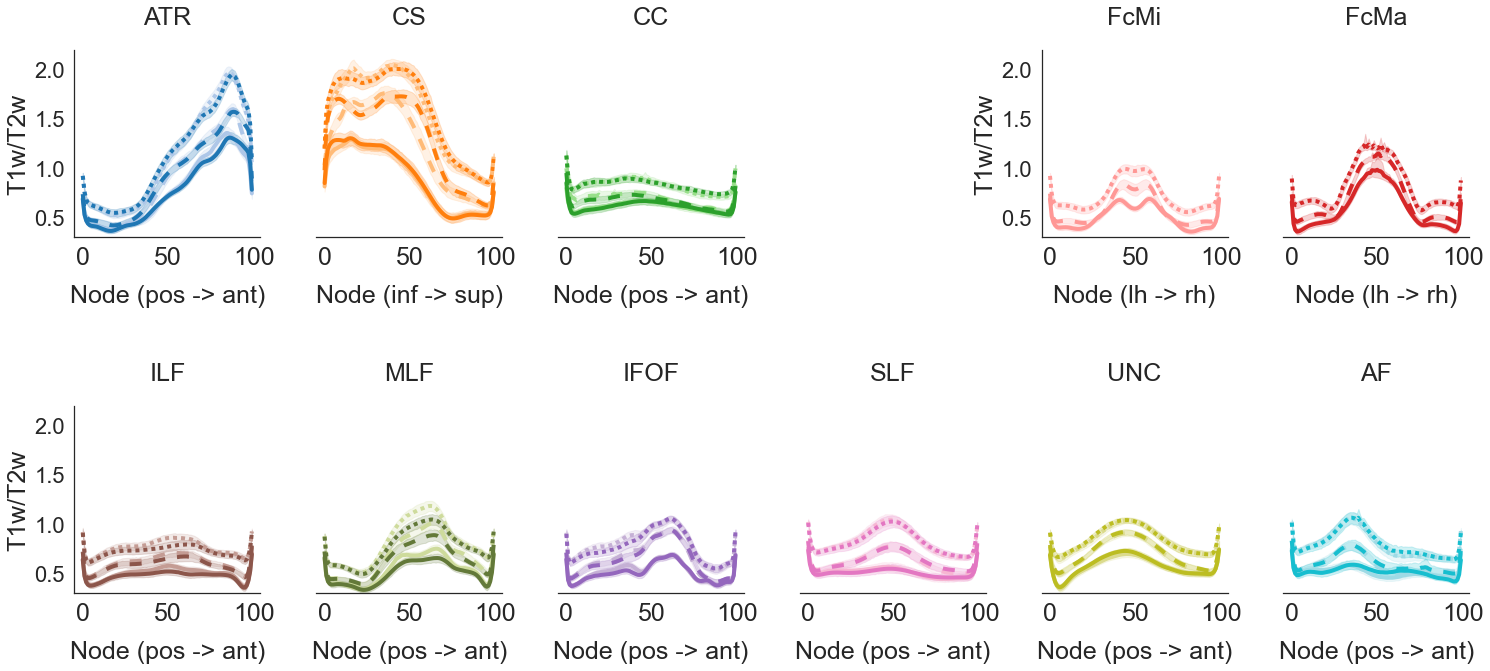

In [7]:
#This generates Fig 3 in the main manuscript
#sort matched data into gropus and plot developement
#group 1: preterm babies scaned at birth
#gruop 2: preterm babies scanned full-term
#group 3: full-term babies matched to preterm babies scanned full-term

age0=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==1]
age0['scan_age'].mean()
age0.shape
age1=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==2]
age1['scan_age'].mean()
age1.shape
age2=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==3]
age2['scan_age'].mean()
age2.shape

sns.set(font_scale = 2)
sns.set_style('white');
matchedData=allDataMergedCleaned[allDataMergedCleaned['matched_groups']>0]

df= matchedData;

fig, axes = plt.subplots(2,6,frameon=False,figsize=(25,10));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);
sns.set(font_scale = 2);

ct = 0;
for tractName in tractCount:
    
    ax=axes[tractPos[tracts[ct]]];    
    currentTract=df.query("tractID == @tractName");
    sns.set_style('white');
    
    group=1
    currentGroup=currentTract.query("matched_groups == @group");
    fig1=sns.lineplot(data=currentGroup, x='nodeID', y='R1',hue='matched_groups',legend=False, style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    group=2
    currentGroup=currentTract.query("matched_groups == @group");
    fig1=sns.lineplot(data=currentGroup, x='nodeID', y='R1',hue='matched_groups',legend=False, dashes=[(3,3)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    group=3
    currentGroup=currentTract.query("matched_groups == @group");
    fig1=sns.lineplot(data=currentGroup, x='nodeID', y='R1',hue='matched_groups',legend=False, dashes=[(1,1)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    
    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    _=ax.set_ylim([0.3,2.2])
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8:
        _=ax.set_ylabel("T1w/T2w",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        #ax.legend([line1,line2],['BB','AB'],loc="upper left",borderpad=0.01,bbox_to_anchor=(0.15,0.2),ncol=2,framealpha=0.75,frameon=True,edgecolor=[1,1,1],prop={'size':20},fancybox=True,handlelength=1.5)
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
sns.set_style('white');
axes[0, 3].axis("off");
plt.show();
fig.savefig('./figures/premi_protracted_developement_t1wt2w.png')

#todo compute and plot difference between PT_scanned_late and FT_scanned late
# x=2(a-b/a+b)

<bound method Figure.tight_layout of <Figure size 1800x720 with 12 Axes>>

(0.0, 1.0, 0.0, 1.0)

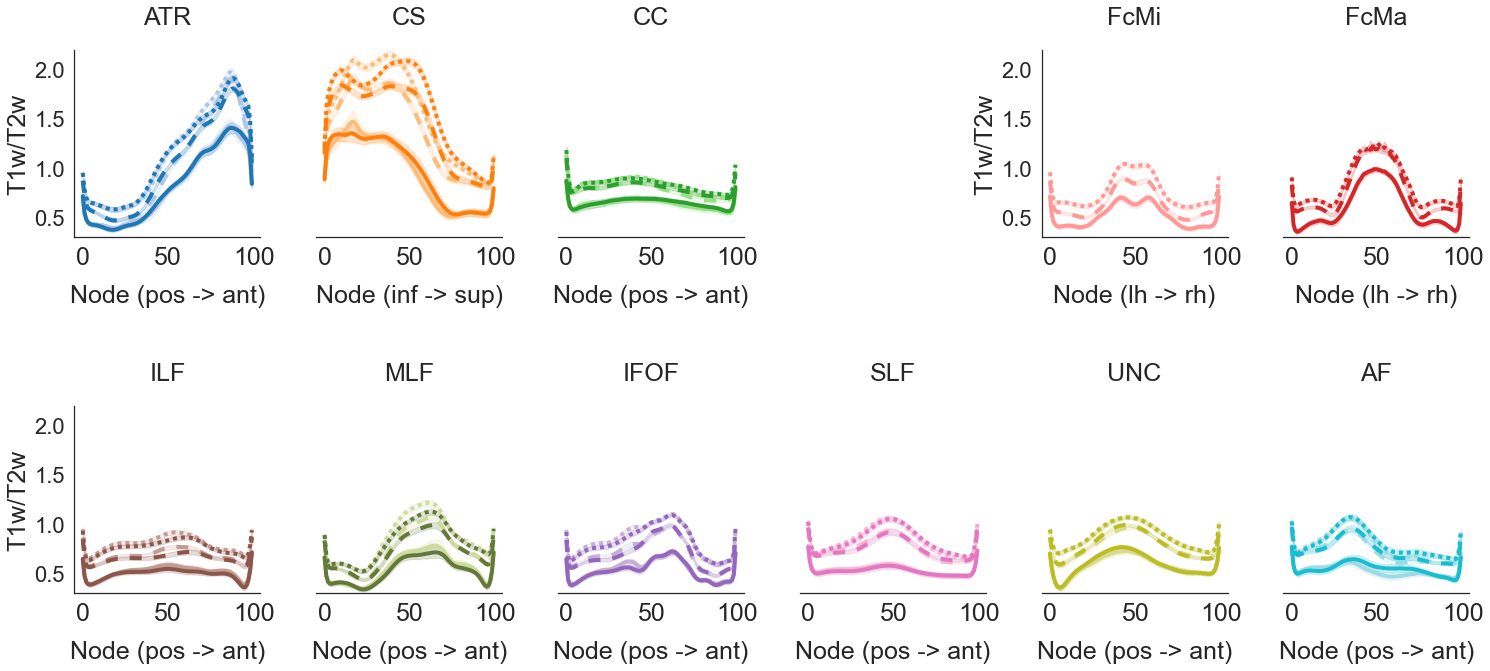

In [8]:
# this generates fig 1 in the main manuscript
#now we are moving to the second, non-longi sample
#here we create a simple plot of dev over time

allDataCleanedNoLongi=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
allDataCleanedNoLongiIU=allDataCleanedNoLongi[allDataCleanedNoLongi["timeAfterBirth"]<=4]
allDataCleanedNoLongiIU['ageBin']=0
allDataCleanedNoLongiIU['ageBin'][(allDataCleanedNoLongiIU['scan_age']>=33) & (allDataCleanedNoLongiIU['scan_age']<37)]=33
allDataCleanedNoLongiIU['ageBin'][(allDataCleanedNoLongiIU['scan_age']>=37) & (allDataCleanedNoLongiIU['scan_age']<41)]=37
allDataCleanedNoLongiIU['ageBin'][(allDataCleanedNoLongiIU['scan_age']>=41) & (allDataCleanedNoLongiIU['scan_age']<45)]=41

allDataCleanedNoLongiIUBinned=allDataCleanedNoLongiIU[allDataCleanedNoLongiIU['ageBin']>0]
df= allDataCleanedNoLongiIUBinned;

fig, axes = plt.subplots(2,6,frameon=False,figsize=(25,10));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);
sns.set(font_scale = 2);
sns.set_style('white');

ct = 0;
for tractName in tractCount:
    ax=axes[tractPos[tracts[ct]]];
    _=ax.set_ylim([0.3,2.2])
    currentTract=df.query("tractID == @tractName");
    sns.set_style('white');
    
    bin=33
    currentBin=currentTract.query("ageBin == @bin");
    fig1=sns.lineplot(data=currentBin, x='nodeID', y='R1',hue='ageBin' ,legend=False, style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    bin=37
    currentBin=currentTract.query("ageBin == @bin");
    fig1=sns.lineplot(data=currentBin, x='nodeID', y='R1',hue='ageBin' ,legend=False, dashes=[(3,3)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    bin=41
    currentBin=currentTract.query("ageBin == @bin");
    fig1=sns.lineplot(data=currentBin, x='nodeID', y='R1',hue='ageBin' ,legend=False, dashes=[(1,1)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    
    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8:
        _=ax.set_ylabel("T1w/T2w",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        #ax.legend([line1,line2],['BB','AB'],loc="upper left",borderpad=0.01,bbox_to_anchor=(0.15,0.2),ncol=2,framealpha=0.75,frameon=True,edgecolor=[1,1,1],prop={'size':20},fancybox=True,handlelength=1.5)
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
axes[0, 3].axis("off");
sns.set_style('white');
plt.show();
fig.savefig('./figures/sample1_different_scan_ages.png')


In [31]:
#compute slope for scan age along bundles, no normalization

allDataCleanedNoLongi=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
tractCount.shape
coeff=[] #Creating arrays
se = []
coeffType=[]
tractTrack1=[]
nodeTrack1=[]
intercept=[]
r2 = []
aic = []
pvals=[]
    
for tract in tractCount:
        
    for node in nodeCount:
        
        dfForStats=allDataCleanedNoLongi[(allDataCleanedNoLongi['tractID']==tract) & (allDataCleanedNoLongi['nodeID']==node)]
        dfForStats.reset_index(level=0, inplace=True)

        scanAgeArray=np.array(dfForStats['scan_age'])
        scanAgeArray=scanAgeArray.reshape(1,-1)
        scanAgeNorm=preprocessing.normalize(scanAgeArray,axis=1)
        scanAgeNorm=scanAgeNorm.reshape(-1)
        dfForStats["scanAgeNorm"]=scanAgeNorm

        birthAgeArray=np.array(dfForStats['birth_age'])
        birthAgeArray=birthAgeArray.reshape(1,-1)
        birthAgeNorm=preprocessing.normalize(birthAgeArray,axis=1)
        birthAgeNorm=birthAgeNorm.reshape(-1)
        dfForStats["birthAgeNorm"]=birthAgeNorm

        timeAfterBirthArray=np.array(dfForStats['timeAfterBirth'])
        timeAfterBirthArray=timeAfterBirthArray.reshape(1,-1)
        timeAfterBirthNorm=preprocessing.normalize(timeAfterBirthArray,axis=1)
        timeAfterBirthNorm=timeAfterBirthNorm.reshape(-1)
        dfForStats["timeAfterBirthNorm"]=timeAfterBirthNorm

        dti_mdArray=np.array(dfForStats['dti_md'])
        dti_mdArray=dti_mdArray.reshape(1,-1)
        dti_mdNorm=preprocessing.normalize(dti_mdArray,axis=1)
        dti_mdNorm=dti_mdNorm.reshape(-1)
        dfForStats["dti_mdNorm"]=dti_mdNorm
        
        R1Array=np.array(dfForStats['R1'])
        R1Array=R1Array.reshape(1,-1)
        R1Norm=preprocessing.normalize(R1Array,axis=1)
        R1Norm=R1Norm.reshape(-1)
        dfForStats["R1Norm"]=R1Norm
            #dfForStats.head()

            #dfForStats.to_csv('./'+tract+'_dataCleanedForLME.csv')
        df = dfForStats
        md = smf.ols(formula="R1~ 1 + scan_age", data=df) #Predicting dti_mdNorm through the other variables
        mdf = md.fit() # Actually commanding the linear analysis, it could be any other analysis method
        results=mdf.summary()

# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
        results_as_html = results.tables[1].as_html()
        LM_results=pd.read_html(results_as_html, header=0, index_col=0)[0]
        
        results_as_html_R2 = results.tables[0].as_html()
        LM_results_R2=pd.read_html(results_as_html_R2, index_col=0)[0]
        
        results_R2s=LM_results_R2[3]
        #LM_results.head()
        SE=LM_results['std err']
        
        inter=mdf.params['Intercept']
        intercept.append(inter)
        
        #SE.head()
        se.append(SE["scan_age"])
        coeff.append(mdf.params['scan_age'])
        type=3
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type) #Add another line below
        r2.append(results_R2s['Dep. Variable:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])        
        
print(mdf.summary())
df=pd.DataFrame(tractTrack1)
df.columns=['tract']
df.insert(1,"node",nodeTrack1)
df.insert(2,"coeffType",coeffType)
df.insert(3,"coeff",coeff)
df.insert(4,"se",se)
df.insert(5,"intercept",intercept)
df.insert(6,"r2",r2)
df.insert(7,"aic",aic)
df.insert(8,"pvals",pvals)

df.to_csv('./data/LM_result_scanAge_noNorm.csv')
df.head()
df.min(axis=0)
df.max(axis=0)
df.mean(axis=0)
dfScanAge=df
df.head()

statsPerBundle=df.groupby('tract').mean()
statsPerBundle.head()
statsPerBundle.to_csv('./data/LM_result_scanAge_noNorm_meanPerBundle.csv')

(20,)

                            OLS Regression Results                            
Dep. Variable:                     R1   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     367.8
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           5.92e-54
Time:                        16:19:16   Log-Likelihood:                 342.63
No. Observations:                 300   AIC:                            -681.3
Df Residuals:                     298   BIC:                            -673.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3494      0.066     -5.255      0.0

,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,3,0.031287,0.002,-0.290048,0.476,-601.0,9.650000e-44
1,ARC_R,1,3,0.027750,0.002,-0.346934,0.386,-562.6,1.900000e-33
2,ARC_R,2,3,0.024947,0.002,-0.307168,0.318,-537.2,1.260000e-26
3,ARC_R,3,3,0.024405,0.002,-0.302087,0.305,-531.2,2.510000e-25
4,ARC_R,4,3,0.024947,0.002,-0.320010,0.310,-525.4,8.090000e-26


tract           ARC_L
node                0
coeffType           3
coeff        0.017829
se              0.002
intercept   -3.506772
r2              0.113
aic            -708.6
pvals             0.0
dtype: object

tract           UNC_R
node               99
coeffType           3
coeff        0.130221
se              0.006
intercept    0.133714
r2              0.757
aic             47.31
pvals             0.0
dtype: object

node         4.950000e+01
coeffType    3.000000e+00
coeff        4.043047e-02
se           2.571000e-03
intercept   -7.817558e-01
r2           4.356665e-01
aic         -4.418654e+02
pvals        2.978848e-12
dtype: float64

,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,3,0.031287,0.002,-0.290048,0.476,-601.0,9.650000e-44
1,ARC_R,1,3,0.027750,0.002,-0.346934,0.386,-562.6,1.900000e-33
2,ARC_R,2,3,0.024947,0.002,-0.307168,0.318,-537.2,1.260000e-26
3,ARC_R,3,3,0.024405,0.002,-0.302087,0.305,-531.2,2.510000e-25
4,ARC_R,4,3,0.024947,0.002,-0.320010,0.310,-525.4,8.090000e-26


,node,coeffType,coeff,se,intercept,r2,aic,pvals
tract,,,,,,,,
ARC_L,49.5,3.0,0.033286,0.00289,-0.603873,0.31153,-367.616000,2.869047e-11
ARC_R,49.5,3.0,0.033198,0.00268,-0.609898,0.33052,-404.892000,1.962113e-15
ATR_L,49.5,3.0,0.042160,0.00270,-0.658089,0.43477,-396.761000,7.941510e-26
ATR_R,49.5,3.0,0.043302,0.00334,-0.704110,0.35382,-286.098464,3.819350e-12
CGC_L,49.5,3.0,0.023351,0.00203,-0.152486,0.29861,-554.015000,5.452999e-21


In [15]:
#same as above but without the PTs
#compute slope for scan age along bundles, no normalization

allDataCleanedNoLongiAll=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
allDataCleanedNoLongiAll.shape
allDataCleanedNoLongi=allDataCleanedNoLongiAll[allDataCleanedNoLongiAll['birth_age']>=37]
allDataCleanedNoLongi.shape
tractCount.shape
coeff=[] #Creating arrays
se = []
coeffType=[]
tractTrack1=[]
nodeTrack1=[]
intercept=[]
r2 = []
aic = []
pvals=[]
    
for tract in tractCount:
        
    for node in nodeCount:
        
        dfForStats=allDataCleanedNoLongi[(allDataCleanedNoLongi['tractID']==tract) & (allDataCleanedNoLongi['nodeID']==node)]
        dfForStats.reset_index(level=0, inplace=True)

        scanAgeArray=np.array(dfForStats['scan_age'])
        scanAgeArray=scanAgeArray.reshape(1,-1)
        scanAgeNorm=preprocessing.normalize(scanAgeArray,axis=1)
        scanAgeNorm=scanAgeNorm.reshape(-1)
        dfForStats["scanAgeNorm"]=scanAgeNorm

        birthAgeArray=np.array(dfForStats['birth_age'])
        birthAgeArray=birthAgeArray.reshape(1,-1)
        birthAgeNorm=preprocessing.normalize(birthAgeArray,axis=1)
        birthAgeNorm=birthAgeNorm.reshape(-1)
        dfForStats["birthAgeNorm"]=birthAgeNorm

        timeAfterBirthArray=np.array(dfForStats['timeAfterBirth'])
        timeAfterBirthArray=timeAfterBirthArray.reshape(1,-1)
        timeAfterBirthNorm=preprocessing.normalize(timeAfterBirthArray,axis=1)
        timeAfterBirthNorm=timeAfterBirthNorm.reshape(-1)
        dfForStats["timeAfterBirthNorm"]=timeAfterBirthNorm

        dti_mdArray=np.array(dfForStats['dti_md'])
        dti_mdArray=dti_mdArray.reshape(1,-1)
        dti_mdNorm=preprocessing.normalize(dti_mdArray,axis=1)
        dti_mdNorm=dti_mdNorm.reshape(-1)
        dfForStats["dti_mdNorm"]=dti_mdNorm
        
        R1Array=np.array(dfForStats['R1'])
        R1Array=R1Array.reshape(1,-1)
        R1Norm=preprocessing.normalize(R1Array,axis=1)
        R1Norm=R1Norm.reshape(-1)
        dfForStats["R1Norm"]=R1Norm
            #dfForStats.head()

            #dfForStats.to_csv('./'+tract+'_dataCleanedForLME.csv')
        df = dfForStats
        md = smf.ols(formula="R1~ 1 + scan_age", data=df) #Predicting dti_mdNorm through the other variables
        mdf = md.fit() # Actually commanding the linear analysis, it could be any other analysis method
        results=mdf.summary()

# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
        results_as_html = results.tables[1].as_html()
        LM_results=pd.read_html(results_as_html, header=0, index_col=0)[0]
        
        results_as_html_R2 = results.tables[0].as_html()
        LM_results_R2=pd.read_html(results_as_html_R2, index_col=0)[0]
        
        results_R2s=LM_results_R2[3]
        #LM_results.head()
        SE=LM_results['std err']
        
        inter=mdf.params['Intercept']
        intercept.append(inter)
        
        #SE.head()
        se.append(SE["scan_age"])
        coeff.append(mdf.params['scan_age'])
        type=3
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type) #Add another line below
        r2.append(results_R2s['Dep. Variable:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])        
        
print(mdf.summary())
df=pd.DataFrame(tractTrack1)
df.columns=['tract']
df.insert(1,"node",nodeTrack1)
df.insert(2,"coeffType",coeffType)
df.insert(3,"coeff",coeff)
df.insert(4,"se",se)
df.insert(5,"intercept",intercept)
df.insert(6,"r2",r2)
df.insert(7,"aic",aic)
df.insert(8,"pvals",pvals)

df.to_csv('./data/LM_result_noNorm_noPT_scanAge.csv')


(600000, 24)

(468000, 24)

(20,)

                            OLS Regression Results                            
Dep. Variable:                     R1   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     80.01
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           1.21e-16
Time:                        13:13:43   Log-Likelihood:                 281.24
No. Observations:                 234   AIC:                            -558.5
Df Residuals:                     232   BIC:                            -551.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0647      0.115     -0.561      0.5

,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,3,0.017758,0.003,0.278813,0.118,-501.6,6.890000e-08
1,ARC_R,1,3,0.010091,0.003,0.391761,0.037,-470.7,3.340000e-03
2,ARC_R,2,3,0.005098,0.004,0.521443,0.009,-449.4,1.540000e-01
3,ARC_R,3,3,0.004030,0.004,0.548002,0.005,-446.9,2.620000e-01
4,ARC_R,4,3,0.005043,0.004,0.510682,0.008,-440.7,1.660000e-01


tract           ARC_L
node                0
coeffType           3
coeff        -0.00312
se              0.003
intercept   -2.319488
r2                0.0
aic            -566.3
pvals             0.0
dtype: object

tract           UNC_R
node               99
coeffType           3
coeff        0.101668
se              0.011
intercept    1.147785
r2              0.499
aic             62.73
pvals           0.863
dtype: object

node          49.500000
coeffType      3.000000
coeff          0.033611
se             0.004590
intercept     -0.490286
r2             0.193624
aic         -346.020491
pvals          0.007144
dtype: float64

,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,1,0.041216,0.004,-0.629296,0.366,-576.9,1.310000e-23
1,ARC_R,0,2,-0.010128,0.004,-0.629296,0.366,-576.9,1.310000e-23
2,ARC_R,1,1,0.035689,0.004,-0.599250,0.320,-550.1,4.830000e-20
3,ARC_R,1,2,-0.020341,0.004,-0.599250,0.320,-550.1,4.830000e-20
4,ARC_R,2,1,0.032172,0.004,-0.526713,0.306,-530.9,4.590000e-19


,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,3,0.017758,0.003,0.278813,0.118,-501.6,6.890000e-08
1,ARC_R,1,3,0.010091,0.003,0.391761,0.037,-470.7,3.340000e-03
2,ARC_R,2,3,0.005098,0.004,0.521443,0.009,-449.4,1.540000e-01
3,ARC_R,3,3,0.004030,0.004,0.548002,0.005,-446.9,2.620000e-01
4,ARC_R,4,3,0.005043,0.004,0.510682,0.008,-440.7,1.660000e-01


,tract,node,coeffType_x,coeff_x,se_x,intercept_x,r2_x,aic_x,pvals_x,coeffType_y,coeff_y,se_y,intercept_y,r2_y,aic_y,pvals_y
0,ARC_R,0,2,-0.010128,0.004,-0.629296,0.366,-576.9,1.310000e-23,3,0.017758,0.003,0.278813,0.118,-501.6,6.890000e-08
1,ARC_R,1,2,-0.020341,0.004,-0.599250,0.320,-550.1,4.830000e-20,3,0.010091,0.003,0.391761,0.037,-470.7,3.340000e-03
2,ARC_R,2,2,-0.027089,0.004,-0.526713,0.306,-530.9,4.590000e-19,3,0.005098,0.004,0.521443,0.009,-449.4,1.540000e-01
3,ARC_R,3,2,-0.028512,0.004,-0.511736,0.307,-529.5,3.910000e-19,3,0.004030,0.004,0.548002,0.005,-446.9,2.620000e-01
4,ARC_R,4,2,-0.027224,0.005,-0.540072,0.296,-519.1,2.310000e-18,3,0.005043,0.004,0.510682,0.008,-440.7,1.660000e-01


0       75.3
1       79.4
2       81.5
3       82.6
4       78.4
        ... 
1995    38.1
1996    41.3
1997    43.3
1998    43.4
1999    38.9
Length: 2000, dtype: float64


23.031529935000012

-1.3000000000000114

97.69999999999999

In [33]:

#compute slope for birth age and time after birth along bundles, no normalization

allDataCleanedNoLongi=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
allDataCleanedNoLongi.shape
tractCount.shape

coeff=[] #Creating arrays
se = []
r2 = []
aic = []
pvals=[]
coeffType=[]
tractTrack1=[]
nodeTrack1=[]
intercept=[]
    
for tract in tractCount:
        
    for node in nodeCount:
        
        dfForStats=allDataCleanedNoLongi[(allDataCleanedNoLongi['tractID']==tract) & (allDataCleanedNoLongi['nodeID']==node)]
        dfForStats.reset_index(level=0, inplace=True)

        scanAgeArray=np.array(dfForStats['scan_age'])
        scanAgeArray=scanAgeArray.reshape(1,-1)
        scanAgeNorm=preprocessing.normalize(scanAgeArray,axis=1)
        scanAgeNorm=scanAgeNorm.reshape(-1)
        dfForStats["scanAgeNorm"]=scanAgeNorm

        birthAgeArray=np.array(dfForStats['birth_age'])
        birthAgeArray=birthAgeArray.reshape(1,-1)
        birthAgeNorm=preprocessing.normalize(birthAgeArray,axis=1)
        birthAgeNorm=birthAgeNorm.reshape(-1)
        dfForStats["birthAgeNorm"]=birthAgeNorm

        timeAfterBirthArray=np.array(dfForStats['timeAfterBirth'])
        timeAfterBirthArray=timeAfterBirthArray.reshape(1,-1)
        timeAfterBirthNorm=preprocessing.normalize(timeAfterBirthArray,axis=1)
        timeAfterBirthNorm=timeAfterBirthNorm.reshape(-1)
        dfForStats["timeAfterBirthNorm"]=timeAfterBirthNorm

        dti_mdArray=np.array(dfForStats['dti_md'])
        dti_mdArray=dti_mdArray.reshape(1,-1)
        dti_mdNorm=preprocessing.normalize(dti_mdArray,axis=1)
        dti_mdNorm=dti_mdNorm.reshape(-1)
        dfForStats["dti_mdNorm"]=dti_mdNorm
        
        R1Array=np.array(dfForStats['R1'])
        R1Array=R1Array.reshape(1,-1)
        R1Norm=preprocessing.normalize(R1Array,axis=1)
        R1Norm=R1Norm.reshape(-1)
        dfForStats["R1Norm"]=R1Norm
            #dfForStats.head()

            #dfForStats.to_csv('./'+tract+'_dataCleanedForLME.csv')
        df = dfForStats
        md = smf.ols(formula="R1~ 1 + birth_age + timeAfterBirth", data=df) #Predicting dti_mdNorm through the other variables
        mdf = md.fit() # Actually commanding the linear analysis, it could be any other analysis method
        results=mdf.summary()

# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
        results_as_html = results.tables[1].as_html()
        LM_results=pd.read_html(results_as_html, header=0, index_col=0)[0]
        
        results_as_html_R2 = results.tables[0].as_html()
        LM_results_R2=pd.read_html(results_as_html_R2, index_col=0)[0]     
        results_R2s=LM_results_R2[3]
        
        type=1
        #LM_results.head()
        SE=LM_results['std err']
        inter=mdf.params['Intercept']
        intercept.append(inter)
        se.append(SE["birth_age"])
        coeff.append(mdf.params['birth_age'])
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type) #Add another line below
        
        type=2
        coeff.append(mdf.params['timeAfterBirth'])
        se.append(SE["timeAfterBirth"])
        r2.append(results_R2s['Dep. Variable:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type)
        intercept.append(inter)
        r2.append(results_R2s['Dep. Variable:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])
        
print(mdf.summary())
df=pd.DataFrame(tractTrack1)
df.columns=['tract']
df.insert(1,"node",nodeTrack1)
df.insert(2,"coeffType",coeffType)
df.insert(3,"coeff",coeff)
df.insert(4,"se",se)
df.insert(5,"intercept",intercept)
df.insert(6,"r2",r2)
df.insert(7,"aic",aic)
df.insert(8,"pvals",pvals)

df.to_csv('./data/LM_result_inUtero_exUtero_noNorm.csv')
df.head()
df.min(axis=0)
df.max(axis=0)
dfInUteroExUtero=df

#df.min(axis=0)
#df.max(axis=0)
#df.mean(axis=0)
#dfInUtero=df[df['coeffType']==1]
#dfInUtero.min(axis=0)
#dfInUtero.max(axis=0)
#dfInUtero.mean(axis=0)
#dfExUtero=df[df['coeffType']==2]
#dfExUtero.min(axis=0)
#dfExUtero.max(axis=0)
#dfExUtero.mean(axis=0)

dfInUteroExUtero.head()
dfScanAge.head()
dfExUtero=dfInUteroExUtero[dfInUteroExUtero['coeffType']==2]
dfM=pd.merge(dfExUtero,dfScanAge, on=["tract","node"], how="inner")
dfM.head()
aic=dfM['aic_y']-dfM['aic_x']

print(aic)
aic.mean(axis=0)
aic.min(axis=0)
aic.max(axis=0)

statsPerBundle=df.groupby('tract').mean()
statsPerBundle.head()
statsPerBundle.to_csv('./data/LM_result_inUtero_exUtero_noNorm_meanPerBundle.csv')

df=dfInUteroExUtero[dfInUteroExUtero['coeffType']==1]
statsPerBundle=df.groupby('tract').mean()
statsPerBundle.head()
statsPerBundle.to_csv('./data/LM_result_inUtero_exUtero_noNorm_meanPerBundleInUtero.csv')

df=dfInUteroExUtero[dfInUteroExUtero['coeffType']==2]
statsPerBundle=df.groupby('tract').mean()
statsPerBundle.head()
statsPerBundle.to_csv('./data/LM_result_inUtero_exUtero_noNorm_meanPerBundleExUtero.csv')

(600000, 24)

(20,)

                            OLS Regression Results                            
Dep. Variable:                     R1   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     293.0
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           5.34e-71
Time:                        16:50:47   Log-Likelihood:                 385.48
No. Observations:                 300   AIC:                            -765.0
Df Residuals:                     297   BIC:                            -753.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3749      0.058     -6.

,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,1,0.032808,0.002,-0.320761,0.621,-696.0,2.790000e-63
1,ARC_R,0,2,0.014091,0.002,-0.320761,0.621,-696.0,2.790000e-63
2,ARC_R,1,1,0.029319,0.002,-0.378621,0.545,-650.5,1.580000e-51
3,ARC_R,1,2,0.010009,0.002,-0.378621,0.545,-650.5,1.580000e-51
4,ARC_R,2,1,0.026562,0.002,-0.339786,0.490,-622.3,3.580000e-44


tract           ARC_L
node                0
coeffType           1
coeff        0.002069
se              0.001
intercept   -3.577199
r2              0.139
aic            -772.5
pvals             0.0
dtype: object

tract           UNC_R
node               99
coeffType           2
coeff        0.133599
se              0.008
intercept    0.115681
r2              0.817
aic             22.75
pvals             0.0
dtype: object

,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,1,0.032808,0.002,-0.320761,0.621,-696.0,2.790000e-63
1,ARC_R,0,2,0.014091,0.002,-0.320761,0.621,-696.0,2.790000e-63
2,ARC_R,1,1,0.029319,0.002,-0.378621,0.545,-650.5,1.580000e-51
3,ARC_R,1,2,0.010009,0.002,-0.378621,0.545,-650.5,1.580000e-51
4,ARC_R,2,1,0.026562,0.002,-0.339786,0.490,-622.3,3.580000e-44


,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,3,0.031287,0.002,-0.290048,0.476,-601.0,9.650000e-44
1,ARC_R,1,3,0.027750,0.002,-0.346934,0.386,-562.6,1.900000e-33
2,ARC_R,2,3,0.024947,0.002,-0.307168,0.318,-537.2,1.260000e-26
3,ARC_R,3,3,0.024405,0.002,-0.302087,0.305,-531.2,2.510000e-25
4,ARC_R,4,3,0.024947,0.002,-0.320010,0.310,-525.4,8.090000e-26


,tract,node,coeffType_x,coeff_x,se_x,intercept_x,r2_x,aic_x,pvals_x,coeffType_y,coeff_y,se_y,intercept_y,r2_y,aic_y,pvals_y
0,ARC_R,0,2,0.014091,0.002,-0.320761,0.621,-696.0,2.790000e-63,3,0.031287,0.002,-0.290048,0.476,-601.0,9.650000e-44
1,ARC_R,1,2,0.010009,0.002,-0.378621,0.545,-650.5,1.580000e-51,3,0.027750,0.002,-0.346934,0.386,-562.6,1.900000e-33
2,ARC_R,2,2,0.006685,0.003,-0.339786,0.490,-622.3,3.580000e-44,3,0.024947,0.002,-0.307168,0.318,-537.2,1.260000e-26
3,ARC_R,3,2,0.005761,0.003,-0.335389,0.484,-618.4,2.330000e-43,3,0.024405,0.002,-0.302087,0.305,-531.2,2.510000e-25
4,ARC_R,4,2,0.006242,0.003,-0.353420,0.485,-611.3,1.470000e-43,3,0.024947,0.002,-0.320010,0.310,-525.4,8.090000e-26


0       95.0
1       87.9
2       85.1
3       87.2
4       85.9
        ... 
1995    68.0
1996    72.8
1997    77.7
1998    83.1
1999    83.7
Length: 2000, dtype: float64


36.02230979999998

-1.0

129.90000000000003

,node,coeffType,coeff,se,intercept,r2,aic,pvals
tract,,,,,,,,
ARC_L,49.5,1.5,0.026121,0.003320,-0.631950,0.38369,-401.7300,8.029215e-14
ARC_R,49.5,1.5,0.026333,0.003095,-0.636803,0.40477,-441.0590,1.836798e-17
ATR_L,49.5,1.5,0.034152,0.003015,-0.689472,0.51311,-443.5160,2.633902e-26
ATR_R,49.5,1.5,0.034934,0.003795,-0.736901,0.42357,-321.6743,2.515390e-16
CGC_L,49.5,1.5,0.017249,0.002395,-0.176397,0.39836,-598.2170,2.718026e-29


,node,coeffType,coeff,se,intercept,r2,aic,pvals
tract,,,,,,,,
ARC_L,49.5,1.0,0.034676,0.00274,-0.631950,0.38369,-401.7300,8.029215e-14
ARC_R,49.5,1.0,0.034530,0.00254,-0.636803,0.40477,-441.0590,1.836798e-17
ATR_L,49.5,1.0,0.043714,0.00251,-0.689472,0.51311,-443.5160,2.633902e-26
ATR_R,49.5,1.0,0.044926,0.00313,-0.736901,0.42357,-321.6743,2.515390e-16
CGC_L,49.5,1.0,0.024535,0.00202,-0.176397,0.39836,-598.2170,2.718026e-29


,node,coeffType,coeff,se,intercept,r2,aic,pvals
tract,,,,,,,,
ARC_L,49.5,2.0,0.017566,0.00390,-0.631950,0.38369,-401.7300,8.029215e-14
ARC_R,49.5,2.0,0.018135,0.00365,-0.636803,0.40477,-441.0590,1.836798e-17
ATR_L,49.5,2.0,0.024590,0.00352,-0.689472,0.51311,-443.5160,2.633902e-26
ATR_R,49.5,2.0,0.024943,0.00446,-0.736901,0.42357,-321.6743,2.515390e-16
CGC_L,49.5,2.0,0.009964,0.00277,-0.176397,0.39836,-598.2170,2.718026e-29


In [9]:
#same as above but without the PTs
#compute slope for birth age and time after birth along bundles, no normalization

allDataCleanedNoLongiAll=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
allDataCleanedNoLongiAll.shape
allDataCleanedNoLongi=allDataCleanedNoLongiAll[allDataCleanedNoLongiAll['birth_age']>=37]
allDataCleanedNoLongi.shape
tractCount.shape
coeff=[] #Creating arrays
se = []
r2 = []
aic = []
pvals=[]
coeffType=[]
tractTrack1=[]
nodeTrack1=[]
intercept=[]
    
for tract in tractCount:
        
    for node in nodeCount:
        
        dfForStats=allDataCleanedNoLongi[(allDataCleanedNoLongi['tractID']==tract) & (allDataCleanedNoLongi['nodeID']==node)]
        dfForStats.reset_index(level=0, inplace=True)

        scanAgeArray=np.array(dfForStats['scan_age'])
        scanAgeArray=scanAgeArray.reshape(1,-1)
        scanAgeNorm=preprocessing.normalize(scanAgeArray,axis=1)
        scanAgeNorm=scanAgeNorm.reshape(-1)
        dfForStats["scanAgeNorm"]=scanAgeNorm

        birthAgeArray=np.array(dfForStats['birth_age'])
        birthAgeArray=birthAgeArray.reshape(1,-1)
        birthAgeNorm=preprocessing.normalize(birthAgeArray,axis=1)
        birthAgeNorm=birthAgeNorm.reshape(-1)
        dfForStats["birthAgeNorm"]=birthAgeNorm

        timeAfterBirthArray=np.array(dfForStats['timeAfterBirth'])
        timeAfterBirthArray=timeAfterBirthArray.reshape(1,-1)
        timeAfterBirthNorm=preprocessing.normalize(timeAfterBirthArray,axis=1)
        timeAfterBirthNorm=timeAfterBirthNorm.reshape(-1)
        dfForStats["timeAfterBirthNorm"]=timeAfterBirthNorm

        dti_mdArray=np.array(dfForStats['dti_md'])
        dti_mdArray=dti_mdArray.reshape(1,-1)
        dti_mdNorm=preprocessing.normalize(dti_mdArray,axis=1)
        dti_mdNorm=dti_mdNorm.reshape(-1)
        dfForStats["dti_mdNorm"]=dti_mdNorm
        
        R1Array=np.array(dfForStats['R1'])
        R1Array=R1Array.reshape(1,-1)
        R1Norm=preprocessing.normalize(R1Array,axis=1)
        R1Norm=R1Norm.reshape(-1)
        dfForStats["R1Norm"]=R1Norm
            #dfForStats.head()

            #dfForStats.to_csv('./'+tract+'_dataCleanedForLME.csv')
        df = dfForStats
        md = smf.ols(formula="R1~ 1 + birth_age + timeAfterBirth", data=df) #Predicting dti_mdNorm through the other variables
        mdf = md.fit() # Actually commanding the linear analysis, it could be any other analysis method
        results=mdf.summary()

# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
        results_as_html = results.tables[1].as_html()
        LM_results=pd.read_html(results_as_html, header=0, index_col=0)[0]
        
        results_as_html_R2 = results.tables[0].as_html()
        LM_results_R2=pd.read_html(results_as_html_R2, index_col=0)[0]     
        results_R2s=LM_results_R2[3]
        
        type=1
        #LM_results.head()
        SE=LM_results['std err']
        inter=mdf.params['Intercept']
        intercept.append(inter)
        se.append(SE["birth_age"])
        coeff.append(mdf.params['birth_age'])
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type) #Add another line below
        
        type=2
        coeff.append(mdf.params['timeAfterBirth'])
        se.append(SE["timeAfterBirth"])
        r2.append(results_R2s['Dep. Variable:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type)
        intercept.append(inter)
        r2.append(results_R2s['Dep. Variable:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])
        
print(mdf.summary())
df=pd.DataFrame(tractTrack1)
df.columns=['tract']
df.insert(1,"node",nodeTrack1)
df.insert(2,"coeffType",coeffType)
df.insert(3,"coeff",coeff)
df.insert(4,"se",se)
df.insert(5,"intercept",intercept)
df.insert(6,"r2",r2)
df.insert(7,"aic",aic)
df.insert(8,"pvals",pvals)

df.to_csv('./data/LM_result_inUtero_exUtero_noNorm_noPT.csv')
df.head()
df.min(axis=0)
df.max(axis=0)
dfInUteroExUtero=df

#df.min(axis=0)
#df.max(axis=0)
#df.mean(axis=0)
#dfInUtero=df[df['coeffType']==1]
#dfInUtero.min(axis=0)
#dfInUtero.max(axis=0)
#dfInUtero.mean(axis=0)
dfExUtero=df[df['coeffType']==2]
dfExUtero.min(axis=0)
dfExUtero.max(axis=0)
Utero.mean(axis=0)


(600000, 24)

(468000, 24)

(20,)

                            OLS Regression Results                            
Dep. Variable:                     R1   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     69.48
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           2.37e-24
Time:                        12:44:32   Log-Likelihood:                 301.68
No. Observations:                 234   AIC:                            -597.4
Df Residuals:                     231   BIC:                            -587.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6716      0.140     -4.

,tract,node,coeffType,coeff,se,intercept,r2,aic,pvals
0,ARC_R,0,1,0.041216,0.004,-0.629296,0.366,-576.9,1.310000e-23
1,ARC_R,0,2,-0.010128,0.004,-0.629296,0.366,-576.9,1.310000e-23
2,ARC_R,1,1,0.035689,0.004,-0.599250,0.320,-550.1,4.830000e-20
3,ARC_R,1,2,-0.020341,0.004,-0.599250,0.320,-550.1,4.830000e-20
4,ARC_R,2,1,0.032172,0.004,-0.526713,0.306,-530.9,4.590000e-19


tract           ARC_L
node                0
coeffType           1
coeff       -0.042825
se              0.003
intercept   -4.298028
r2              0.011
aic            -625.2
pvals             0.0
dtype: object

tract           UNC_R
node               99
coeffType           2
coeff        0.151496
se              0.015
intercept    0.545495
r2              0.562
aic             38.27
pvals           0.285
dtype: object

tract           ARC_L
node                0
coeffType           2
coeff       -0.042825
se              0.004
intercept   -4.298028
r2              0.011
aic            -625.2
pvals             0.0
dtype: object

tract           UNC_R
node               99
coeffType           2
coeff        0.047172
se              0.015
intercept    0.545495
r2              0.562
aic             38.27
pvals           0.285
dtype: object

NameError: name 'Utero' is not defined

In [ ]:
#predict R1 in preterm from scanAge model 

dfLM=pd.read_csv('./data/LM_result_R1_noNorm_scanAge.csv');
allDataCleanedNoLongi=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
tractCount=allDataCleanedNoLongi['tractID'].unique()
tractCount.shape

coeffType1=dfLM[dfLM['coeffType']==3];

dfLM.head(20)
groupsMergedCleanedPTSL.head()
R1Predicted=[]
R1Meassured=[]
R1pred=[]
tractCount=groupsMergedCleanedPTSL['tractID'].unique()
tractCount.shape

print(tractCount)
nodeCount=groupsMergedCleanedPTSL['nodeID'].unique()
nodeCount.shape
print(nodeCount)
subjectsCount=groupsMergedCleanedPTSL['subjectID'].unique()
subjectsCount.shape
print(subjectsCount)

for subject in subjectsCount:

    for tract in tractCount:
        
        for node in nodeCount:
            
            groupsMergedCleanedPTSLForStats=groupsMergedCleanedPTSL[(groupsMergedCleanedPTSL['subjectID']==subject) & (groupsMergedCleanedPTSL['tractID']==tract) & (groupsMergedCleanedPTSL['nodeID']==node)]
            groupsMergedCleanedPTSLForStats.reset_index(level=0, inplace=True)
            #print(groupsMergedCleanedPTSLForStats['R1'])
            
            coeffType1ForStats=coeffType1[(coeffType1['tract']==tract) & (coeffType1['node']==node)]
            coeffType1ForStats.reset_index(level=0, inplace=True)

            R1pred=groupsMergedCleanedPTSLForStats['scan_age_x']*coeffType1ForStats['coeff'] + coeffType1ForStats['intercept']
            
            R1Meassured.append(groupsMergedCleanedPTSLForStats['R1'])
            
            R1Predicted.append(R1pred)

df=pd.DataFrame(R1Predicted)
df.columns=['R1PredictedScanAge']

df.to_csv('./data/groupsMergedCleanedPTSL_predicted_R1_scanAge.csv')


In [ ]:
#predict R1 in preterm from inUtero exUTero model 

dfLM=pd.read_csv('./data/LM_result_R1_noNorm.csv');
groupsMergedCleanedPTSL=pd.read_csv('./data/LM_result_inUtero_exUtero_noNorm.csv')

coeffType1=dfLM[dfLM['coeffType']==1];
coeffType2=dfLM[dfLM['coeffType']==2];
dfLM.head(20)
groupsMergedCleanedPTSL.head()
R1Predicted=[]
R1pred=[]
tractCount=groupsMergedCleanedPTSL['tractID'].unique()
tractCount.shape
print(tractCount)

nodeCount=groupsMergedCleanedPTSL['nodeID'].unique()
nodeCount.shape
print(nodeCount)

subjectsCount=groupsMergedCleanedPTSL['subjectID'].unique()
subjectsCount.shape
print(subjectsCount)

for subject in subjectsCount:

    for tract in tractCount:
        
        for node in nodeCount:
            
            groupsMergedCleanedPTSLForStats=groupsMergedCleanedPTSL[(groupsMergedCleanedPTSL['subjectID']==subject) & (groupsMergedCleanedPTSL['tractID']==tract) & (groupsMergedCleanedPTSL['nodeID']==node)]
            groupsMergedCleanedPTSLForStats.reset_index(level=0, inplace=True)
            
            coeffType1ForStats=coeffType1[(coeffType1['tract']==tract) & (coeffType1['node']==node)]
            coeffType1ForStats.reset_index(level=0, inplace=True)
            
            coeffType2ForStats=coeffType2[(coeffType2['tract']==tract) & (coeffType2['node']==node)]
            coeffType2ForStats.reset_index(level=0, inplace=True)
            
            R1pred=groupsMergedCleanedPTSLForStats['birth_age_x']*coeffType1ForStats['coeff'] + groupsMergedCleanedPTSLForStats['timeAfterBirth']*coeffType2ForStats['coeff'] + coeffType2ForStats['intercept']
            R1Predicted.append(R1pred)
            
df=pd.DataFrame(R1Predicted)
df.columns=['R1PredictedexUT']
df.shape
df.head
df.tail

df.to_csv('./data/groupsMergedCleanedPTSL_predicted_R1_exUT.csv')

In [ ]:
#stats for predicting preterm at term aquivalent age from different models
dfPTSL=pd.read_csv('./data/groupsMergedCleanedPTSL.csv');
dfPredscanAge=pd.read_csv('./data/groupsMergedCleanedPTSL_predicted_R1_scanAge.csv');
dfPredexUT=pd.read_csv('./data/groupsMergedCleanedPTSL_predicted_R1_exUT.csv');

dfIn=pd.concat([dfPTSL,dfPredscanAge,dfPredexUT],axis=1)

dfMerged=dfIn.groupby(["tractID","nodeID"], as_index=False).mean()
dfMerged.head()

diffR1ScanAge=dfMerged["R1"]-dfMerged['R1PredictedScanAge']
print(diffR1ScanAge.mean())
print(diffR1ScanAge.std())
diffR1ExUT=dfMerged["R1"]-dfMerged['R1PredictedexUT']
print(diffR1ExUT.mean())
print(diffR1ExUT.std())

df = dfMerged.iloc[::10, :]
df.head()
tractCount=dfIn['tractID'].unique()
tractCount.shape


corrScanAge=scipy.stats.pearsonr(df['R1'],df['R1PredictedScanAge'])
print(corrScanAge)
fig5=sns.lmplot(data=df,x="R1",y="R1PredictedScanAge", palette='viridis',sharex=False,aspect=1.25)
#plt.plot(R1Meassured, R1Predicted,'o', color='black')
#for tractName in tractCount:
#    currentTract=df.query("tractID == @tractName");
#    corrScanAge=scipy.stats.pearsonr(currentTract['R1'],currentTract['R1PredictedScanAge'])
#    print(corrScanAge)

corrExUtero=scipy.stats.pearsonr(df['R1'],df['R1PredictedexUT'])
print(corrExUtero)
fig5=sns.lmplot(data=df,x="R1",y="R1PredictedexUT", palette='viridis',sharex=False,aspect=1.25)
    

In [ ]:
dfPTSL=pd.read_csv('./data/groupsMergedCleanedPTSL.csv');
dfPredscanAge=pd.read_csv('./data/groupsMergedCleanedPTSL_predicted_R1_scanAge.csv');
dfPredexUT=pd.read_csv('./data/groupsMergedCleanedPTSL_predicted_R1_exUT.csv');

dfIn=pd.concat([dfPTSL,dfPredscanAge,dfPredexUT],axis=1)

dfMerged=dfIn.groupby(["tractID","nodeID"], as_index=False).mean()
dfMerged.head()

df= dfIn;


fig, axes = plt.subplots(2,6,frameon=False,figsize=(25,10));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);
sns.set(font_scale = 2);
sns.set_style('white');

ct = 0;
for tractName in tractCount:
    ax=axes[tractPos[tracts[ct]]];
    _=ax.set_ylim([0.3,2])
    currentTract=df.query("tractID == @tractName");
    sns.set_style('white');
    grey_colors=sns.color_palette("Greys", 8)
    
    if (ct % 2) == 0: 
        fig1=sns.lineplot(data=currentTract, x='nodeID', y='R1PredictedScanAge',hue=1, legend=False, dashes=[(3,3)], style=True, ax=ax, palette=[grey_colors[2]], linewidth=4)
        fig1=sns.lineplot(data=currentTract, x='nodeID', y='R1PredictedexUT',hue=1, legend=False, dashes=[(1,1)], style=True, ax=ax, palette=[grey_colors[6]], linewidth=4)
    else:
        fig1=sns.lineplot(data=currentTract, x='nodeID', y='R1PredictedScanAge',hue=1, legend=False, dashes=[(3,3)], style=True, ax=ax, palette=[grey_colors[3]], linewidth=4)
        fig1=sns.lineplot(data=currentTract, x='nodeID', y='R1PredictedexUT',hue=1, legend=False, dashes=[(1,1)], style=True, ax=ax, palette=[grey_colors[7]], linewidth=4)
    
    fig1=sns.lineplot(data=currentTract, x='nodeID', y='R1',legend=False, hue=1, style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4,alpha=0.65)
    
    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8:
        _=ax.set_ylabel("T1w/T2w",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        #ax.legend([line1,line2],['BB','AB'],loc="upper left",borderpad=0.01,bbox_to_anchor=(0.15,0.2),ncol=2,framealpha=0.75,frameon=True,edgecolor=[1,1,1],prop={'size':20},fancybox=True,handlelength=1.5)
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
axes[0, 3].axis("off");
sns.set_style('white');
plt.show();
fig.savefig('figures/predict_sampl2_from_sampl1.png')



<bound method Figure.tight_layout of <Figure size 1800x720 with 12 Axes>>

(0.0, 1.0, 0.0, 1.0)

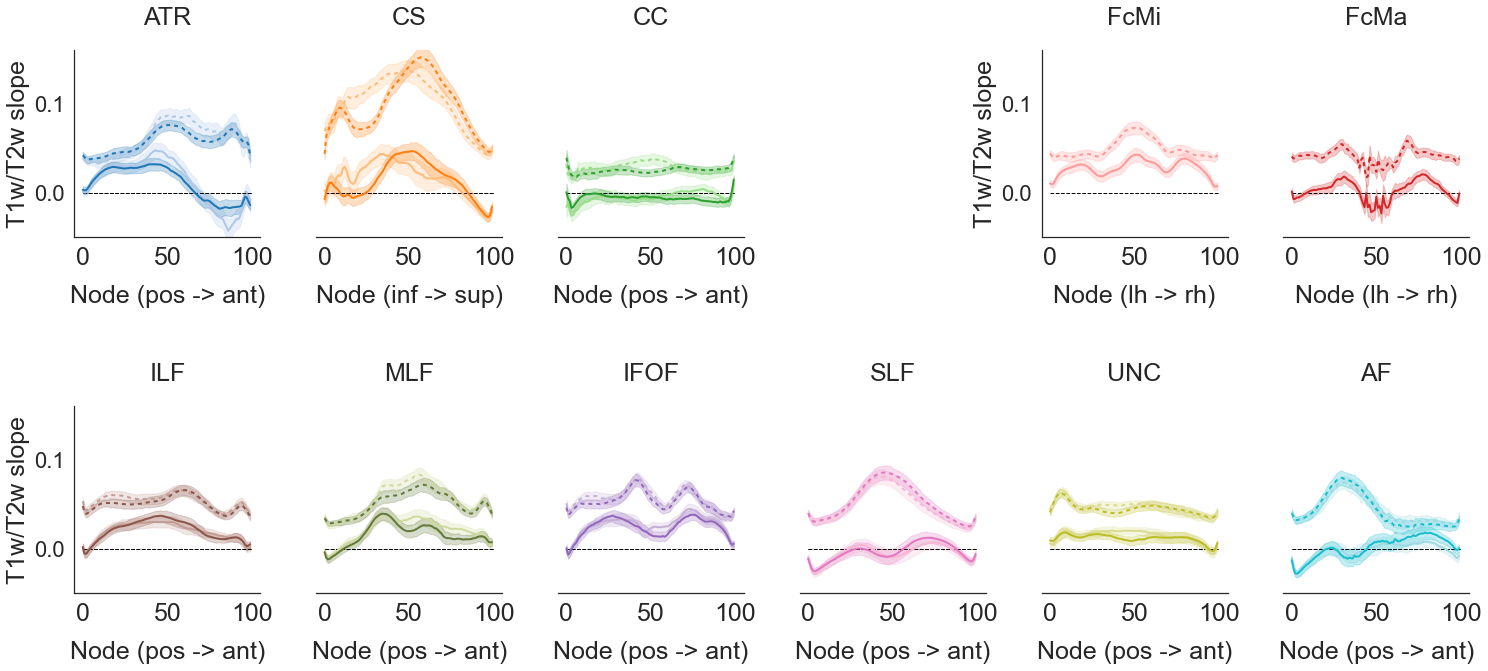

In [13]:
df=pd.read_csv('./data/LM_result_inUtero_exUtero_noNorm_noPT.csv');

coeffType1=df[df['coeffType']==1];
coeffType2=df[df['coeffType']==2];


fig, axes = plt.subplots(2,6,frameon=False,figsize=(25,10));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);

ct = 0;
for tractName in tractCount:
    
    ax=axes[tractPos[tracts[ct]]];    
    currentTract=df.query("tract == @tractName");
    coeffType1CurrentTract=coeffType1.query('tract == @tractName');
    coeffType2CurrentTract=coeffType2.query('tract == @tractName');
    
    sns.set(font_scale = 2);
    sns.set_style('white');
    fig1 = sns.lineplot(data=coeffType1CurrentTract, x='node', y='coeff', hue='coeffType',legend=False, dashes=[(2,2)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=2); #I have changed the palette colour from 'crest' to 'Blues' as my computer didn't recognise that colour
    fig1 = sns.lineplot(data=coeffType2CurrentTract, x='node', y='coeff', hue='coeffType' ,legend=False, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=2);
    fig1 = ax.fill_between(coeffType1CurrentTract["node"], coeffType1CurrentTract['coeff']-coeffType1CurrentTract['se'],coeffType1CurrentTract['coeff']+coeffType1CurrentTract['se'],color=[color_list_all[color_order[ct]]],alpha=0.25);
    fig1 = ax.fill_between(coeffType2CurrentTract["node"], coeffType2CurrentTract['coeff']-coeffType2CurrentTract['se'], coeffType2CurrentTract['coeff']+coeffType2CurrentTract['se'], color=[color_list_all[color_order[ct]]],alpha=0.25); 

    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    _=ax.set_ylim([-0.05,0.16])
    _=ax.hlines(y=0, xmin=0, xmax=100, linewidth=1, color='black',linestyle='dashed')
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8:
        _=ax.set_ylabel("T1w/T2w slope",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        


        #ax.legend([line1,line2],['BB','AB'],loc="upper left",borderpad=0.01,bbox_to_anchor=(0.15,0.2),ncol=2,framealpha=0.75,frameon=True,edgecolor=[1,1,1],prop={'size':20},fancybox=True,handlelength=1.5)
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
axes[0, 3].axis("off")
sns.set_style('white');
plt.show();
fig.savefig('./figures/compareCoeffs.png', dpi=600)


In [ ]:
df=pd.read_csv('./data/LM_result_inUtero_exUtero_noNorm_noPT.csv');

coeffType1=df[df['coeffType']==1];
coeffType2=df[df['coeffType']==2];


fig, axes = plt.subplots(2,6,frameon=False,figsize=(25,10));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);

ct = 0;
for tractName in tractCount:
    
    ax=axes[tractPos[tracts[ct]]];    
    currentTract=df.query("tract == @tractName");
    coeffType1CurrentTract=coeffType1.query('tract == @tractName');
    coeffType2CurrentTract=coeffType2.query('tract == @tractName');
    
    sns.set(font_scale = 2);
    sns.set_style('white');
    fig1 = sns.lineplot(data=coeffType1CurrentTract, x='node', y='coeff', hue='coeffType',legend=False, dashes=[(2,2)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=2); #I have changed the palette colour from 'crest' to 'Blues' as my computer didn't recognise that colour
    fig1 = sns.lineplot(data=coeffType2CurrentTract, x='node', y='coeff', hue='coeffType' ,legend=False, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=2);
    fig1 = ax.fill_between(coeffType1CurrentTract["node"], coeffType1CurrentTract['coeff']-coeffType1CurrentTract['se'],coeffType1CurrentTract['coeff']+coeffType1CurrentTract['se'],color=[color_list_all[color_order[ct]]],alpha=0.25);
    fig1 = ax.fill_between(coeffType2CurrentTract["node"], coeffType2CurrentTract['coeff']-coeffType2CurrentTract['se'], coeffType2CurrentTract['coeff']+coeffType2CurrentTract['se'], color=[color_list_all[color_order[ct]]],alpha=0.25); 

    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    _=ax.set_ylim([-0.05,0.16])
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8:
        _=ax.set_ylabel("T1w/T2w slope",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        #ax.legend([line1,line2],['BB','AB'],loc="upper left",borderpad=0.01,bbox_to_anchor=(0.15,0.2),ncol=2,framealpha=0.75,frameon=True,edgecolor=[1,1,1],prop={'size':20},fancybox=True,handlelength=1.5)
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
axes[0, 3].axis("off")
sns.set_style('white');
plt.show();
fig.savefig('./figures/compareCoeffs.png', dpi=600)
